# Practical Assignment — Influence propagation and agent based models

In [104]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

The first part of the assignment is devoted to models of influence propagation: the linear threshold model and independent cascade model. There are many applications of these types of models, for example:
* Rise of a political movement in an unstable society
* “Word-of-mouth” effects: when we have access to plentiful information, such as when we evaluate new technologies, risky financial assets, or job candidates, we often lack the ability to make sense of it; hence, we rely on the advice of trusted friends, colleagues, or advisors
* “Viral marketing” effects in the success of new products
* Adoption of medical and agricultural innovations
* Cascading failures in power systems
* Desicion making by majority voting

Let us consider these models on directed Erdos Renyi graph.

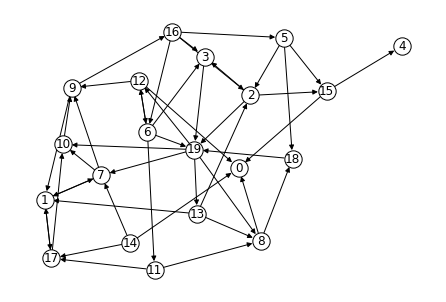

In [105]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

plt.figure(figsize=(6, 4))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='white', edgecolors='black')

### Task 1. Linear threshold model (1 point)

Linear threshold model is defined as follows. Given a choice of all nodes’ thresholds, and an initial set of active nodes, the diffusion process unfolds deterministically in discrete steps: in step $t$, all nodes that were
active in step $t-1$ remain active; furthermore, each currently inactive node becomes active if and only
if the total share of its active neighbors is at least node's threshold.

Write a function `linear_threshold` that takes a graph, np.array `active_nodes` with zeros and ones (if `active_nodes[i]` is 1 then the i-th node is active), np.array of `thresholds`. The function propagates influence and stops when the model stops changing. The function returns a np.array with active nodes in each step. The first step is initial activation, the last and the second to last steps are the same (we want to see that the propogation stops changing).

In [106]:
def linear_threshold(G, active_nodes, thresholds):
    active_nodes_history = [active_nodes]
    while True:
        cur_active_nodes = active_nodes_history[-1].copy()
        inactive_idx = np.argwhere(cur_active_nodes == 0)
        for node_id in inactive_idx:
            neigh = np.array(list(G.predecessors(node_id[0])))
            if neigh.shape[0] == 0:
                continue
            node_rate = np.sum(cur_active_nodes[neigh]) / len(neigh)
            if node_rate >= thresholds[node_id[0]]:
                cur_active_nodes[node_id[0]] = 1

        active_nodes_history.append(cur_active_nodes)
        if np.all(active_nodes_history[-2] == active_nodes_history[-1]):
            break
        
    return np.array(active_nodes_history)

In [107]:
np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

sim = linear_threshold(G, active_nodes, thresholds)

assert sim.shape == (4, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
assert sim[0, 4] == 0
assert sim[2, 4] == 1
assert sim[0, 3] == 0
assert sim[1, 15] == 1

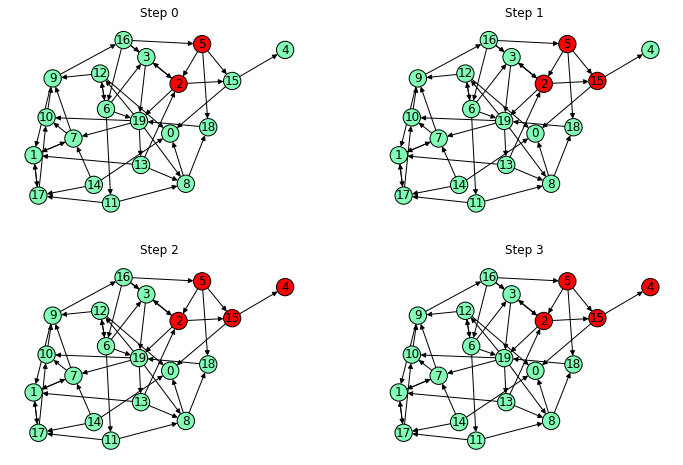

In [108]:
plt.figure(figsize=(6*2, 4*2))

for i, color in enumerate(sim):
    plt.subplot(2, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Task 2. Independent cascade model (3 points)

The next type is Independent cascade model. We again start with an initial set of active nodes, and the process unfolds in discrete steps according to the following randomized rule. When node $v$ first becomes active in step $t$, it is given a single chance to activate each currently inactive neighbor $w$; it succeeds with a probability $p_{v,w}$ — a parameter of the system — independently of the history thus far. (If $w$ has multiple newly activated neighbors, their attempts are sequenced in an arbitrary order.) If $v$ succeeds, then $w$ will become active in step $t+1$; but whether or not $v$ succeeds, it cannot make any further attempts to activate $w$ in subsequent steps.

Write a function `independent_cascade` that takes a graph, np.array active_nodes with zeros and ones (if active_nodes[i] is 1 then the i-th node is active), np.array with propagation probabilities `prop_proba` for edges ordered by `G.edges`. The function propagates influence and stops when the model stops changing. The function returns a np.array with active nodes in each step. The first step is initial activation, the last and the second to last steps are the same (we want to see that the model stops changing).

In [109]:
import random
def independent_cascade(G, active_nodes, prop_proba):
    # history beginning with null for calculating recently active nodes
    active_nodes_history = [np.zeros(len(active_nodes)), active_nodes]
    while True:
        # nodes which just been activated, t
        recently_activated = np.argwhere(active_nodes_history[-1] - active_nodes_history[-2] == 1).reshape(-1)
        # last array with activated nodes
        cur_active_nodes = active_nodes_history[-1].copy()
        # nodes that are not activated 
        inactive_idx = np.argwhere(cur_active_nodes == 0)
        for node_id in recently_activated:
            # propogarion probability
            prob_activate = prop_proba[node_id]

            # neighbours of the node
            neighb = np.array(list(G.predecessors(node_id)))

            # inactivated neighbours of the list > probability to be activated
            inactive = np.random.rand(neighb.shape[0]) < prob_activate

            # chosen randomly neighbours for being activated at t + 1
            chosen = []
            edges_with_node_i = [edge for edge in G.edges() if edge[0] == node_id]

            for edge in edges_with_node_i:
                r = random.random()
                if r >= prob_activate:
                    chosen.append(edge[1])

            if chosen:
                cur_active_nodes[chosen] = 1
        active_nodes_history.append(cur_active_nodes)
        
        if np.all(active_nodes_history[-2] == active_nodes_history[-1]):
            break

    active_nodes_history = active_nodes_history[1:]
    return np.array(active_nodes_history)

In [110]:
np.random.seed(1)
active_nodes = np.zeros(20, 'int')
active_nodes[np.random.choice(np.arange(20), 2, False)] = 1
prop_proba = np.random.rand(len(G.edges))

sims = []
n_steps = []
for i in range(1000):
    sim = independent_cascade(G, active_nodes, prop_proba)
    sims.append(sim)
    n_steps.append(len(sim))
sigma = 1.9165
mean = 5.103
assert mean - 2*sigma < np.mean(n_steps) < mean + 2*sigma
sim = sims[n_steps.index(6)]
assert sim.shape == (6, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
for i in range(1, 4):
    attempts = sim[i] - sim[i-1]
    new_active = sim[i+1] - sim[i]
    has_edge = False
    for j in np.argwhere(attempts == 1):
        for k in np.argwhere(new_active == 1):
            if G.has_edge(j[0], k[0]):
                has_edge = True
    assert has_edge

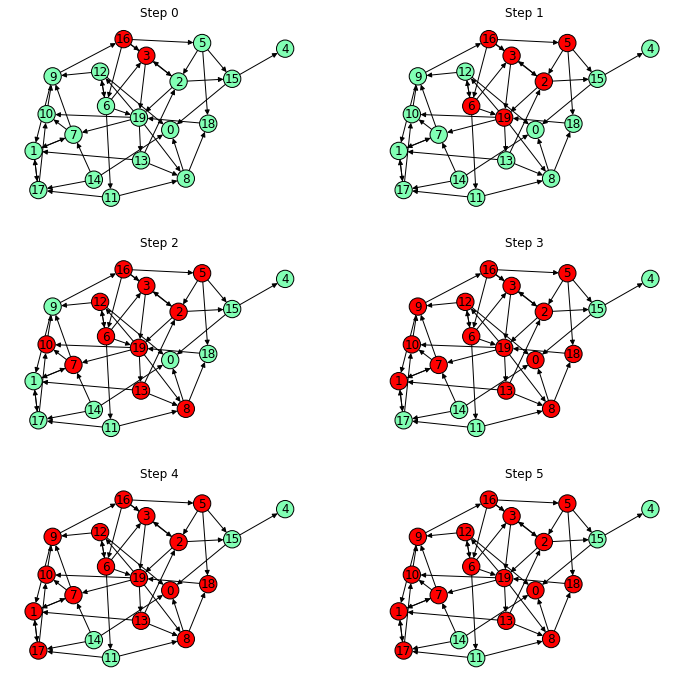

In [111]:
plt.figure(figsize=(6*2, 4*3))

for i, color in enumerate(sim):
    plt.subplot(3, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Task 3. Schelling's segregation model (2 points)

The second part of the assignment is devoted to agent based models: the Schelling's segregation model and game of life model.

We consider Schelling's segregation model on the original structure — 2D regular grid with diagonal edges.

In [112]:
def agent_grid(n):
    G = nx.grid_2d_graph(n, n)
    for node_i in G.nodes:
        for node_j in G.nodes:
            if node_i == node_j: continue
            if (node_i[0] - 1, node_i[1] + 1) == (node_j[0], node_j[1]):
                G.add_edge(node_i, node_j)
            if (node_i[0] + 1, node_i[1] + 1) == (node_j[0], node_j[1]):
                G.add_edge(node_i, node_j)
    return G

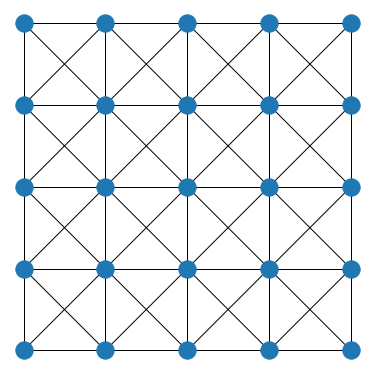

In [113]:
plt.figure(figsize=(5, 5))
G = agent_grid(5)
pos = {node:node for node in G.nodes}
nx.draw(G, pos)

In this model, we have $n$ nodes and $k$ agents, where $k < n$.  Any agent is located in some specific node, so there are $k - n$ empty nodes. All agents are divided into type 0 and type 1. Here is an example of initial positions of agents.

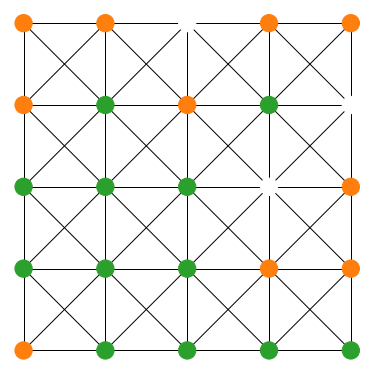

In [114]:
np.random.seed(0)
n_agents = int(len(G) * 0.9)
agent_type = np.random.randint(2, size=n_agents)
agent_loc = []
for i in np.random.choice(range(len(G)), n_agents, False):
    agent_loc.append(list(G.nodes)[i])

colors = plt.cm.tab10.colors[1:]
node_color = []
for node in G.nodes:
    if node not in agent_loc:
        node_color.append((1, 1, 1))
    else:
        node_color.append(colors[agent_type[agent_loc.index(node)]])
plt.figure(figsize=(5,5))
nx.draw(G, pos, node_color=node_color)
plt.show()

The model runs as follows:
1. For each agent, calculate a share of nearest neighbors with opposite type. For example, if a node has 3 neighbors with opposite type and 4 neighbors with the same type, then the share will be 3/7.
2. If the share is bigger than some tolerance level, then the agent is labeled as unhappy.
3. Any unhappy agent relocates to a random empty node.
4. The process repeats until there are almost no unhappy agents left or max iterations is exceeded.

Here is a function `segregation_model` that takes parameters
* `G` — a graph
* `n_agents` — number of agents
* `agent_type` — np.array with zeros and ones. If `agent_type[i]` is 1 then the i-th agent has the type 1.
* `agent_loc` — np.array with agent locations. The i-th agent is located in the `agent_loc[i]` node.
* `tolerance` — tolerance level
* `happiness_threshold` — simulation stops if a happiness threshold is exceeded. Happiness is a share of happy agents.
* `max_iter` — maximum number of simulation steps

The function runs a simulation and returns agent locations in each step.

In [115]:
def segregation_model(G, n_agents, agent_type, agent_loc, 
                      tolerance, happiness_threshold=0.95, 
                      max_iter=100):
    simulation = [agent_loc.copy()]
    happiness = []
    for _ in range(max_iter):
        unhappy_agents = unhappy(G, n_agents, agent_type, 
                                 agent_loc, tolerance)
        happiness.append(1 - len(unhappy_agents) / n_agents)
        if unhappy_agents:
            empty_loc = list(set(G.nodes).difference(agent_loc))
            np.random.shuffle(unhappy_agents)
            np.random.shuffle(empty_loc)
            for i in range(min(len(unhappy_agents), len(empty_loc))):
                agent_loc[unhappy_agents[i]] = empty_loc[i]
        simulation.append(agent_loc.copy())
        if happiness[-1] > happiness_threshold:
            break
    happiness.append(happiness[-1])
    return simulation, happiness

Write a function `unhappy` that takes parameters of `segregation_model` except of `happiness_threshold` and `max_iter`. The function returns a list of unhappy agents.

In [116]:
def unhappy(G, n_agents, agent_type, agent_loc, tolerance):
    unhappy_agents = []
    for i in range(n_agents):
      neighbours = list(G.neighbors(agent_loc[i]))
      types = []
      for neighbour in neighbours:
        if neighbour in agent_loc:
          types.append(int(agent_type[agent_loc.index(neighbour)] != agent_type[i]))
      if len(types) > 0:
        if np.mean(types) > tolerance:
          unhappy_agents.append(i)
    return unhappy_agents

In [117]:
n = 40
G = agent_grid(n)

np.random.seed(0)
n_agents = int(len(G) * 0.9)
agent_type = np.random.randint(2, size=n_agents)
agent_loc = []
for i in np.random.choice(range(len(G)), n_agents, False):
    agent_loc.append(list(G.nodes)[i])
tolerance = 3/7

unhappy_agents = unhappy(G, n_agents, agent_type, agent_loc, tolerance)
assert len(unhappy_agents) == 831
assert sum(unhappy_agents) == 585386
assert unhappy_agents[655] == 1138

Let us make an animation of the simulation by `matplotlib.animation.FuncAnimation`. Here are auxiliary cells to prepare matplotlib objects.

In [118]:
def update(i):
    node_color = []
    for node in G.nodes:
        if node not in sim[i]:
            node_color.append((1, 1, 1))
        else:
            node_color.append(colors[agent_type[sim[i].index(node)]])
    ax.set_title('Happiness: {:.2f}'.format(happiness[i]))
    img = np.array(node_color).reshape((n, n, 3))
    im.set_data(img)
    return(im,)

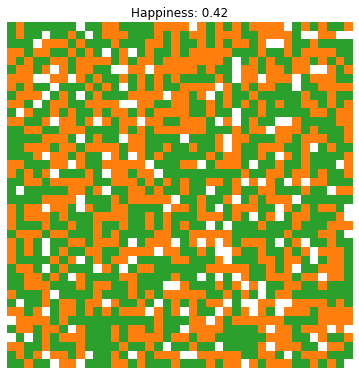

In [119]:
np.random.seed(0)
sim, happiness = segregation_model(G, n_agents, agent_type, 
                                   agent_loc, tolerance, 0.99, 100)

node_color = []
for node in G.nodes:
    if node not in sim[0]:
        node_color.append((1, 1, 1))
    else:
        node_color.append(colors[agent_type[sim[0].index(node)]])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.axis('off')
img = np.array(node_color).reshape((n, n, 3))
ax.set_title('Happiness: {:.2f}'.format(happiness[0]))
im = plt.imshow(img, interpolation='none')

Here is an animation of the segregation model.

In [120]:
ani = FuncAnimation(fig, func=update, frames=len(sim))
HTML(ani.to_jshtml())

### Task 4. Game of life model (2 points)

Game of life is also an agent model that based on simple rules:
1. Any node can be alive or dead.
2. If an alive node has 2 or 3 alive neighbors, it stays alive, otherwise it dies
3. If a dead node has 3 alive neighbors, it comes to life

At each step, we calculate behavior of each node and then simultaneously change behavior of all nodes.

Write a function `game_of_life` that takes a graph, np.array `alive` with ones and zeros where `alive[i]` is equal to 1 if a node `i` is alive. Also a number of steps `k` is passed. The function returns a np.array with alive nodes at each step (it is also array with zeros and ones). The number of steps is `k+1` and the first step contains initial alive nodes.

In [151]:
def game_of_life(G, alive, k=10):
    alive_history = [alive]
    for i in range(1, k+1):
        last_state = alive_history[-1]
        temp = last_state.copy()
        m = {}
        for node in G.nodes:
            neighbors = list(G.neighbors(node))  # All the neighbors
            dead_neighbors = [neighbor for neighbor in neighbors if temp[neighbor] == 0] # Dead neighbors
            alive_neighbors = [neighbor for neighbor in neighbors if temp[neighbor] == 1] # Alive neighbors
            # if the current node is alive, we check if it has 2 or 3 alive neighbors. Else we kill the node
            
            if temp[node] == 1: # If current node alive
                if len(alive_neighbors) in  [2,3]: # Check if it has 2 or 3 neighbors
                    m[node] = 1
                else: # If not, then kill the node
                    m[node] = 0
            # if the current node is dead, we check if it has 3 alive neighbors. Else we resurrect the node
            elif temp[node] == 0:
                if len(alive_neighbors) == 3:
                    m[node] = 1
                else:
                    m[node] = 0
                    
        temp = list(m.values())
        alive_history.append(temp)
        
    return np.array(alive_history)

In [152]:
np.random.seed(0)

n = 30
G = agent_grid(n)
pos = {node:node for node in G.nodes}
G = nx.convert_node_labels_to_integers(G)

alive = np.zeros(n * n, 'int')
alive[np.random.choice(range(n * n), int(n * n * 0.2), False)] = 1

sim = game_of_life(G, alive, 100)
assert sim.shape == (101, 900)
assert sim[0].sum() == 180
assert sim[1].sum() == 176
assert sim[2].sum() == 151

Here are auxiliary cells to prepare matplotlib objects.

In [153]:
def animate(i):
    im.set_data(sim[i].reshape((n, n)))
    return(im,)

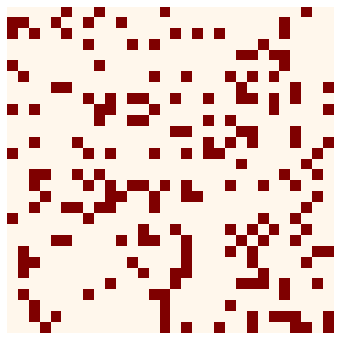

In [154]:
fig = plt.figure(figsize=(6, 6))
plt.axis('off')
im = plt.imshow(sim[0].reshape((n, n)), 
                cmap=plt.cm.OrRd, interpolation='none')

Here is an animation of the game of life.

In [155]:
ani = FuncAnimation(fig, animate, frames=len(sim))
HTML(ani.to_jshtml())

### Task 5. Diffusions on networks (2 points)

A diffusion process is a propagation model, where node values $\phi$ (say, 'heat') spread out of high concentration zone. Consider the diffusion on grid of the size 20x20. Let there be a 3x3 sub-grid with a heat value 3 and a 7x5 sub-grid with a heat value 1. All other nodes has a value 0. The initial heat values is $\phi_0$.

In [156]:
phi_map = np.zeros((20, 20))
phi_map[1:4, 1:4] = 3
phi_map[10:15, 8:15] = 1
phi0 = phi_map.flatten()

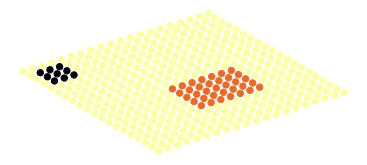

In [157]:
plt.figure(figsize=(7*0.7, 3*0.7))
gridG = nx.grid_2d_graph(20, 20)
nx.draw_kamada_kawai(
    gridG,
    cmap=plt.cm.inferno_r,
    vmin=0, vmax=3,
    width=0,
    node_size=40,
    node_color=phi0)

Create a diffusion simulation based on this diffusion equation

$$\frac{d\phi}{dt} = -CL\phi$$

where $L$ is a graph Laplacian.

Write a function `next_phi` that takes an adjacency matrix `A`, np.array with previous heat values `phi`, constant `C` and time increment `dt`. The function returns a np.array with the next heat values.

In [158]:
def next_phi(A, phi, C, dt):
    g = nx.from_numpy_matrix(A)
    L = nx.laplacian_matrix(g).toarray()
    d_phi = -C*L @ phi.T
    return d_phi*dt + phi

In [159]:
A = nx.to_numpy_array(gridG)
C = 0.1
dt = 2
phi = next_phi(A, phi0, C, dt)
assert phi.shape == (400,)
assert phi.sum() == phi0.sum()
assert phi.std() < phi0.sum()
assert round(phi[20:25].sum(), 4) == 7.2

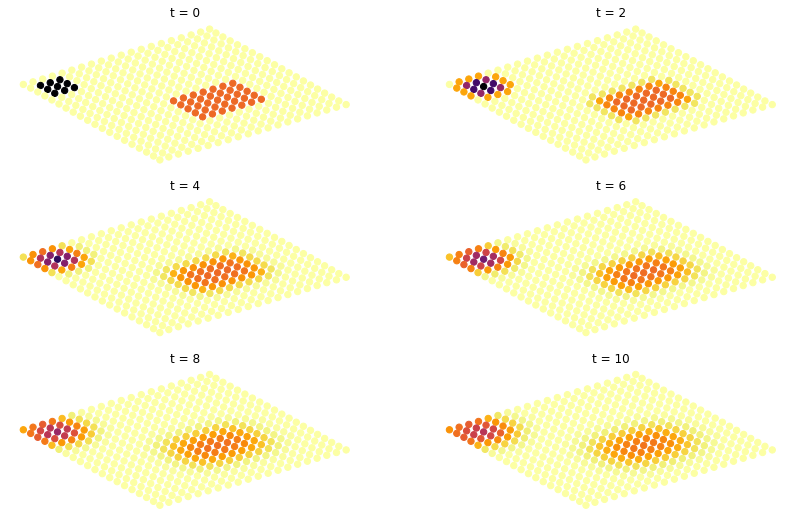

In [160]:
plt.figure(figsize=(7*2, 3*3))

phi = phi0
for i in range(6):
    plt.subplot(3, 2, i+1)
    gridG = nx.grid_2d_graph(20, 20)
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi)
    plt.title('t = {}'.format(i*dt))
    phi = next_phi(A, phi, C, dt)
phi12 = phi

We can run simulation step-by-step as long as we need, but fortunately, there is an analytical solution

$$\phi(t) = \sum_k a_k(t) v_k = \sum_k a_k(0) e^{-C\lambda_k t} v_k$$

where $a_k(t) = \phi(t)^T v_k$ and $v_k$ is k-th smallest eigenvector of a Laplacian.

Write a function `phi_t` that takes an adjacency matrix `A`, np.array with initial heat values `phi0`, constant `C` and time moment `t`. The function returns a np.array with the heat values at time moment `t`. Use `np.linalg.eigh` or `scipy.linalg.eigh` for a symmetric matrix.

In [161]:
def phi_t(A, phi0, C, t):
    w, v = np.linalg.eigh(np.diag(np.sum(A, axis=1)) - A)
    phi_t = np.zeros(phi0.shape)
    for k in range(v.shape[1]):
        phi_t += (phi0.T @ v[:,k]) * np.exp(-C * w[k] * t) * v[:, k]
    res = phi_t
    return res

In [162]:
assert phi_t(A, phi0, C, 0).shape == (400,)
assert round(np.linalg.norm(phi0 - phi_t(A, phi0, C, 0)), 4) == 0
assert round(np.linalg.norm(phi12 - phi_t(A, phi0, C, 12)), 4) < 0.4
assert len(np.unique(phi_t(A, phi0, C, 10000).round(4))) == 1
assert phi_t(A, phi0, C, 10000).round(4)[0] == phi0.sum() / len(phi0)

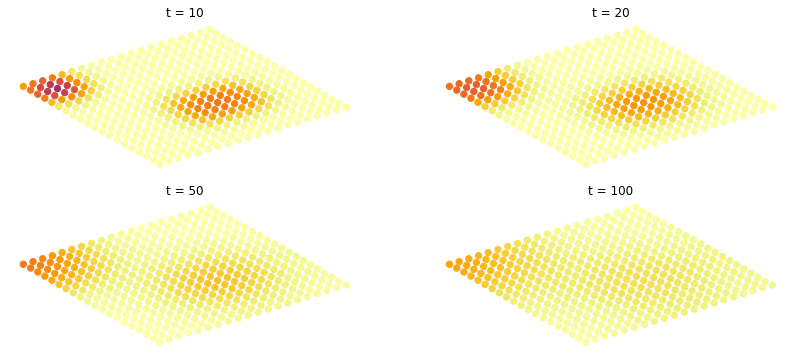

In [163]:
plt.figure(figsize=(7*2, 3*2))
i = 1
for t in [10, 20, 50, 100]:
    plt.subplot(2, 2, i)
    gridG = nx.grid_2d_graph(20, 20)
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi_t(A, phi0, C, t))
    plt.title('t = {}'.format(t))
    i += 1